In [4]:
# CÉLULA 2: IMPORTAÇÕES GLOBAIS
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from collections import Counter
import warnings
import wfdb  # Biblioteca para ler dados do PhysioNet

warnings.filterwarnings('ignore')
print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [ ]:
# CÉLULA 3: CLASSE DE PRÉ-PROCESSAMENTO (ECGPREPROCESSOR) ATUALIZADA

class ECGPreprocessor:
    def __init__(self, target_length=8000, cutoff_freq=30, sampling_rate=300, filter_order=6):
        self.target_length = target_length
        self.cutoff_freq = cutoff_freq
        self.default_sampling_rate = sampling_rate
        self.filter_order = filter_order

    def _apply_butterworth_filter(self, signal, sampling_rate):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = self.cutoff_freq / nyquist
        b, a = butter(self.filter_order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, signal, axis=-1)

    def _crop_or_pad_signal(self, signal):
        current_length = signal.shape[-1]
        if current_length > self.target_length:
            return signal[..., :self.target_length]
        elif current_length < self.target_length:
            padding_size = self.target_length - current_length
            return np.pad(signal, ((0, 0), (0, padding_size)), mode='constant', constant_values=0)
        return signal

    def _normalize_signal(self, signal):
        signal_min, signal_max = np.min(signal), np.max(signal)
        if (signal_max - signal_min) == 0:
            return np.zeros_like(signal)
        return (signal - signal_min) / (signal_max - signal_min)

    def _read_mat_record(self, record_path):
        mat_path = f"{record_path}.mat"
        if not os.path.exists(mat_path): return None
        try:
            signal = scipy.io.loadmat(mat_path)['val']
            return signal.reshape(1, -1)
        except Exception as e:
            print(f"Aviso: Falha ao ler {mat_path}: {e}")
            return None

    def _read_wfdb_record(self, record_path):
        try:
            record = wfdb.rdrecord(record_path)
            try:
                lead_index = record.sig_name.index('II')
            except ValueError:
                lead_index = 0
                print(f"Aviso: Derivação 'II' não encontrada em {record.record_name}. Usando a primeira derivação '{record.sig_name[0]}'.")
            
            signal = record.p_signal.T[lead_index, :].reshape(1, -1)
            filtered_signal = self._apply_butterworth_filter(signal, record.fs)
            return filtered_signal
        except Exception as e:
            print(f"Aviso: Falha ao processar {record_path}: {e}")
            return None
    
    def _load_additional_data(self, data_paths, label, record_reader_func):
        """Função auxiliar para carregar dados de múltiplos diretórios, incluindo subpastas."""
        signals, labels = [], []
        for path in data_paths:
            print(f"  Procurando dados em '{path}' para a classe '{label}'...")
            for root, dirs, files in os.walk(path):
                for filename in files:
                    if filename.endswith('.hea'):
                        record_path = os.path.join(root, filename.replace('.hea', ''))
                        signal = record_reader_func(record_path)
                        if signal is not None:
                            signals.append(signal)
                            labels.append(label)
        return signals, labels

    def process_and_save_dataset(self, base_dir, labels_csv, output_dir, additional_data_paths=None):
        labels_df = pd.read_csv(labels_csv, header=None, names=['record', 'label'])
        print(f"\n--- Processando {len(labels_df)} registros do dataset base ---")
        
        all_signals, all_labels = [], []

        for _, row in labels_df.iterrows():
            record_name, label = row['record'], row['label']
            signal = self._read_mat_record(os.path.join(base_dir, record_name))
            if signal is not None:
                all_signals.append(signal)
                all_labels.append(label)
        
        print(f"Contagem de classes do dataset base: {Counter(all_labels)}")

        if additional_data_paths:
            print("\n--- Carregando dados adicionais para balanceamento ---")
            af_signals, af_labels = self._load_additional_data(additional_data_paths['A'], 'A', self._read_wfdb_record)
            all_signals.extend(af_signals)
            all_labels.extend(af_labels)

            noisy_signals, noisy_labels = self._load_additional_data(additional_data_paths['~'], '~', self._read_wfdb_record)
            all_signals.extend(noisy_signals)
            all_labels.extend(noisy_labels)
            
            print(f"Nova contagem de classes após adicionar dados: {Counter(all_labels)}")

        print("\n--- Aplicando pré-processamento final em todas as amostras ---")
        final_processed_signals = []
        for signal in all_signals:
            filtered_signal = self._apply_butterworth_filter(signal, self.default_sampling_rate)
            resized_signal = self._crop_or_pad_signal(filtered_signal)
            normalized_signal = self._normalize_signal(resized_signal)
            final_processed_signals.append(normalized_signal[0])
        
        os.makedirs(output_dir, exist_ok=True)
        np.save(os.path.join(output_dir, 'processed_signals.npy'), np.array(final_processed_signals))
        pd.DataFrame({'Label': all_labels}).to_csv(os.path.join(output_dir, 'processed_labels.csv'), index=False)
        print(f"\nProcessamento concluído. Total de {len(final_processed_signals)} amostras salvas em '{output_dir}'")

In [ ]:
# CÉLULA 4: EXECUÇÃO DO PIPELINE (VERSÃO FINAL COM NOMES DE PASTA CORRIGIDOS)

# --- 1. Definição Dinâmica dos Caminhos Absolutos ---

DIRETORIO_DO_PROJETO = os.path.abspath("..")
print(f"Diretório raiz do projeto detectado: {DIRETORIO_DO_PROJETO}")

BASE_DADOS_DIR_ORIGINAL = os.path.join(DIRETORIO_DO_PROJETO, "basededados")
BASE_DADOS_DIR_NOVOS = os.path.join(DIRETORIO_DO_PROJETO, "basededados2")

TRAINING_DIR_ORIGINAL = os.path.join(BASE_DADOS_DIR_ORIGINAL, "training2017")
TRAINING_LABELS_CSV = os.path.join(TRAINING_DIR_ORIGINAL, "REFERENCE-original.csv")

additional_data_paths = {
    'A': [
        os.path.join(BASE_DADOS_DIR_NOVOS, "fa", "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3", "records100"),
        os.path.join(BASE_DADOS_DIR_NOVOS, "fa", "af-termination-challenge-database-1.0.0") 
    ],
    '~': [ 
        os.path.join(BASE_DADOS_DIR_NOVOS, "ruidos", "mit-bih-noise-stress-test-database-1.0.0"),
        os.path.join(BASE_DADOS_DIR_NOVOS, "ruidos", "motion-artifact-contaminated-ecg-database-1.0.0")
    ]
}

OUTPUT_DIR_BALANCED = "processed_data_balanced/training"

# --- 2. Verificação dos Caminhos e Execução ---

print(f"\nBuscando dados base em: {TRAINING_DIR_ORIGINAL}")
print(f"Buscando dados adicionais em: {BASE_DADOS_DIR_NOVOS}")
print(f"Salvando dados processados em: {os.path.abspath(OUTPUT_DIR_BALANCED)}")
print("-" * 50)

# Instancia o pré-processador
preprocessor = ECGPreprocessor(target_length=8000)

# Executa o processo completo
preprocessor.process_and_save_dataset(
    base_dir=TRAINING_DIR_ORIGINAL, 
    labels_csv=TRAINING_LABELS_CSV, 
    output_dir=OUTPUT_DIR_BALANCED, 
    additional_data_paths=additional_data_paths
)

print("\n--- Pipeline de pré-processamento finalizado com sucesso! ---")

--- [VERIFICAÇÃO] Carregando dados processados... ---
Forma dos sinais processados: (30464, 8000)
Contagem final das classes processadas: 
A    22650
N     5154
O     2557
~      103
Name: count, dtype: int64

--- [VISUALIZAÇÃO] Plotando amostras aleatórias por classe ---


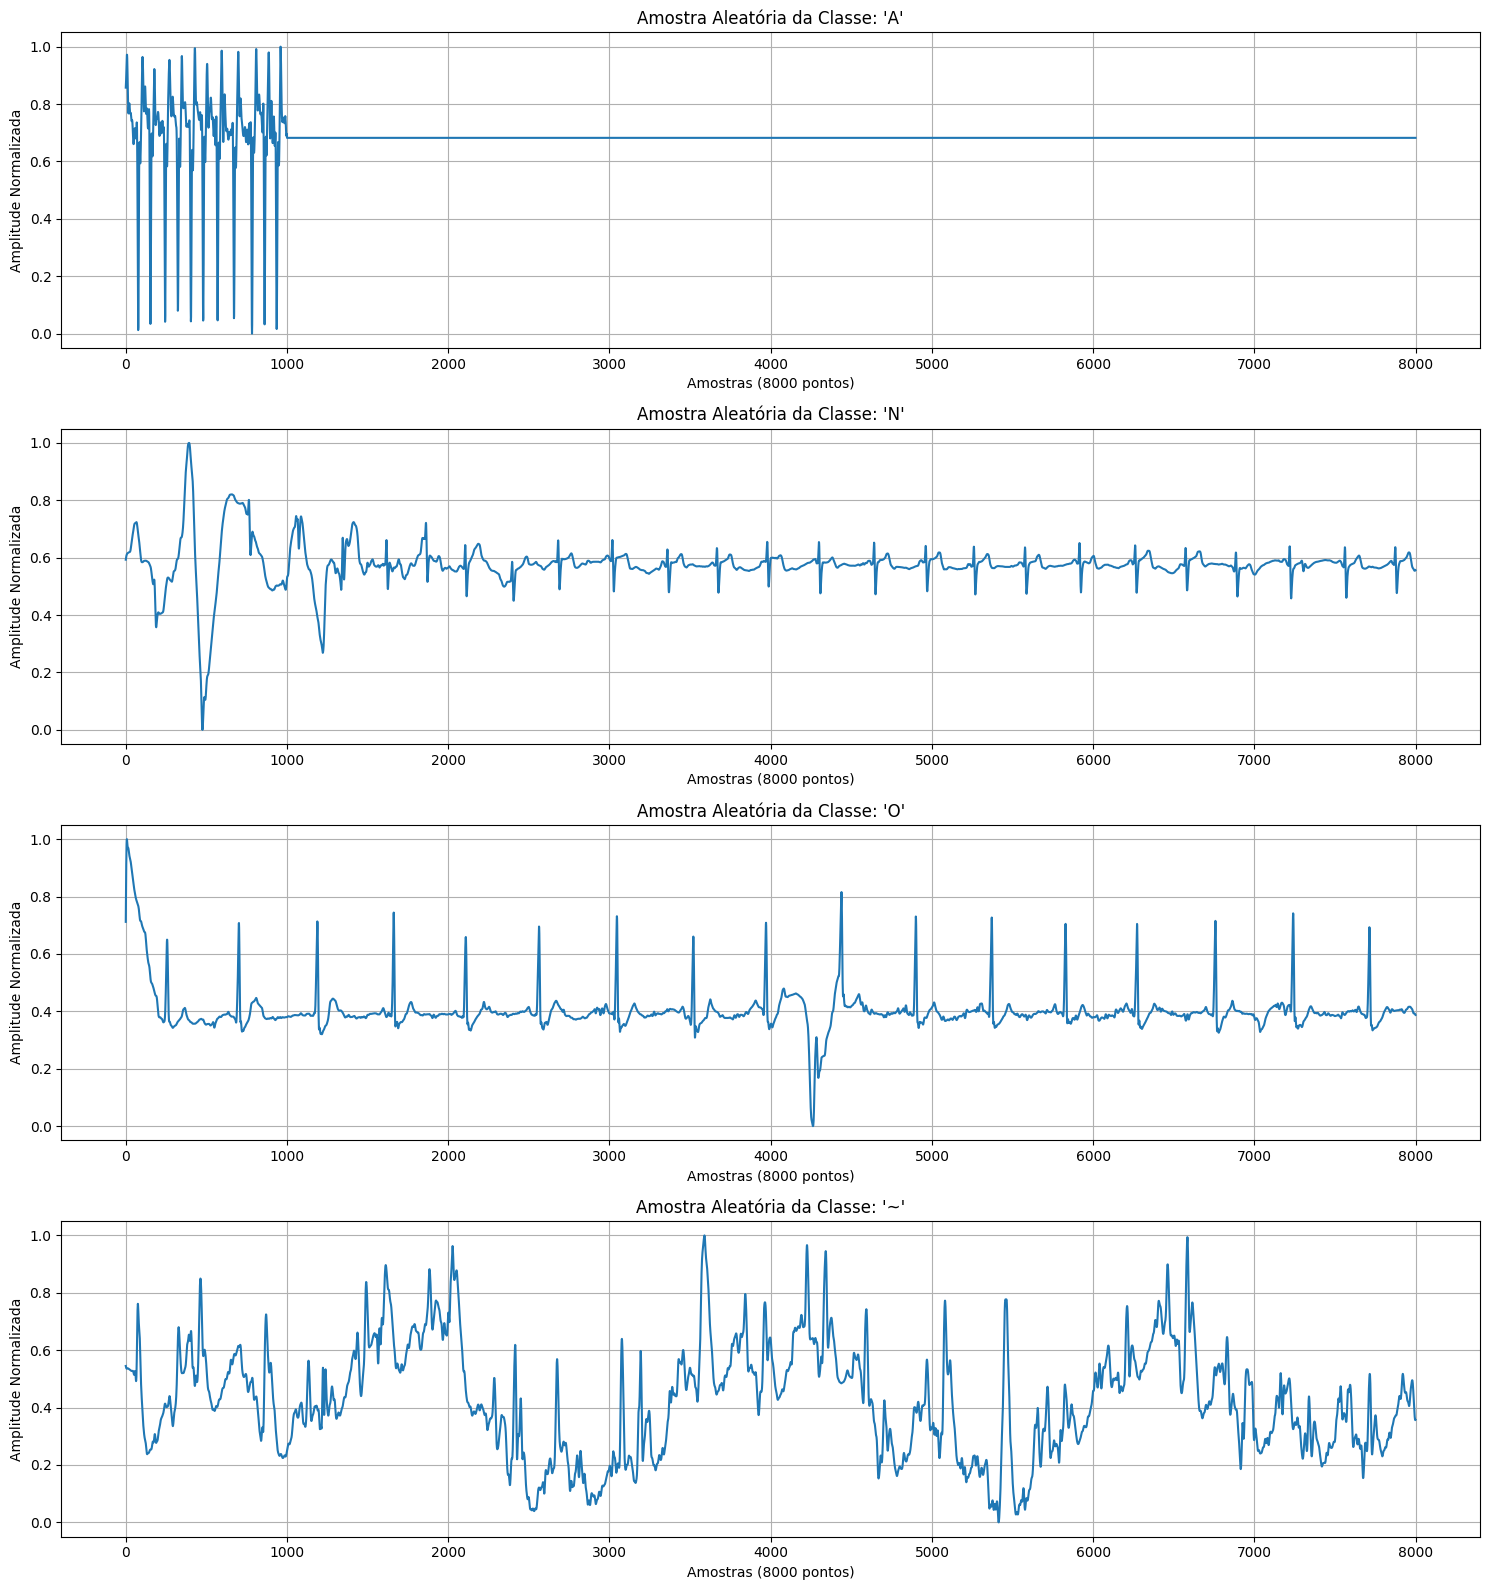

In [19]:
# CÉLULA 5: VERIFICAÇÃO E VISUALIZAÇÃO DOS DADOS PROCESSADOS

print("--- [VERIFICAÇÃO] Carregando dados processados... ---")
signals_path = os.path.join(OUTPUT_DIR_BALANCED, 'processed_signals.npy')
labels_path = os.path.join(OUTPUT_DIR_BALANCED, 'processed_labels.csv')

processed_signals = np.load(signals_path)
processed_labels = pd.read_csv(labels_path)['Label'].values

print(f"Forma dos sinais processados: {processed_signals.shape}")
print(f"Contagem final das classes processadas: \n{pd.Series(processed_labels).value_counts()}")

print("\n--- [VISUALIZAÇÃO] Plotando amostras aleatórias por classe ---")
unique_labels = np.unique(processed_labels)
fig, axes = plt.subplots(len(unique_labels), 1, figsize=(15, 4 * len(unique_labels)))
if len(unique_labels) == 1: axes = [axes]

for i, label in enumerate(unique_labels):
    indices = np.where(processed_labels == label)[0]
    random_index = np.random.choice(indices)
    
    ax = axes[i]
    ax.plot(processed_signals[random_index])
    ax.set_title(f"Amostra Aleatória da Classe: '{label}'")
    ax.set_xlabel(f'Amostras ({processed_signals.shape[1]} pontos)')
    ax.set_ylabel('Amplitude Normalizada')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# CÉLULA DE TESTE: Verificação dos Caminhos e Leitura dos Novos Datasets
import os
import wfdb

print("--- INICIANDO TESTE DE LEITURA DE ARQUIVOS ---\n")

DIRETORIO_DO_PROJETO = os.path.abspath("..")
print(f"Diretório do projeto detectado como: {DIRETORIO_DO_PROJETO}\n")


# Lista dos caminhos exatos que queremos testar
caminhos_para_testar = {
    "PTB-XL (AF)": os.path.join(DIRETORIO_DO_PROJETO, "basededados2", "fa", "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3", "records100"),
    "AF Termination (AF)": os.path.join(DIRETORIO_DO_PROJETO, "basededados2", "fa", "af-termination-challenge-database-1.0.0"),
    "MIT-BIH Noise (Ruído)": os.path.join(DIRETORIO_DO_PROJETO, "basededados2", "ruidos", "mit-bih-noise-stress-test-database-1.0.0"),
    "Motion Artifact (Ruído)": os.path.join(DIRETORIO_DO_PROJETO, "basededados2", "ruidos", "motion-artifact-contaminated-ecg-database-1.0.0")
}

# Loop para verificar cada caminho
for nome_dataset, base_path in caminhos_para_testar.items():
    print(f"--- Verificando o diretório para '{nome_dataset}': {base_path}")
    
    # 1. Verifica se o caminho base existe
    if not os.path.exists(base_path):
        print("    ERRO: O diretório base NÃO EXISTE. Verifique o nome da pasta.")
        continue # Pula para o próximo

    arquivo_encontrado = False
    # 2. Procura por arquivos .hea recursivamente
    for root, dirs, files in os.walk(base_path):
        for filename in files:
            if filename.endswith('.hea'):
                print(f"  - Arquivo .hea encontrado em '{root}': {filename}")
                record_path = os.path.join(root, filename.replace('.hea', ''))
                
                # 3. Tenta ler o arquivo encontrado
                try:
                    record = wfdb.rdrecord(record_path)
                    print(f"    - LIDO COM SUCESSO: {record.record_name}, Derivações: {record.sig_name}")
                    arquivo_encontrado = True
                except Exception as e:
                    print(f"    - ERRO AO LER: {e}")

                break # Para depois de encontrar o primeiro arquivo para acelerar o teste
        if arquivo_encontrado:
            break
            
    if not arquivo_encontrado:
        print("    AVISO: Nenhum arquivo .hea foi encontrado neste diretório e seus subdiretórios.")
    print("-" * 40)

print("\n--- TESTE FINALIZADO ---")